# Description of task
- This is a classification task. 
- In the given data, train.tsv and test.tsv are used for training and testing respectively. The training data is tab sepearted with a label and tokenized sequential data. For example, the tokenized data wr4pi, pze1d, etc.. are actually words of a text document. 
- Each token is a length of 5 (alpha-numeric letters).
- Build your model in this jupyter notebook and submit your prediction results as a csv file along with this notebook
- Try to use PEP 8 style guide.

## Prepare the data. (0pts)

In [1]:
!pip install pandas numpy sklearn matplotlib seaborn 

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, absolute_import, division

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cat
from catboost import CatBoostClassifier


from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential

sns.set_style("ticks")
plt.rcParams['figure.figsize'] = [12, 8]
matplotlib.style.use('seaborn-pastel')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using TensorFlow backend.


In [4]:
train = pd.read_csv(
    'train.tsv', sep='\t', header=None, names=['label','token'])
test = pd.read_csv(
    'test.tsv', sep='\t', header=None, names=['token'])

In [5]:
train['token'] = train.token.str.replace(',', ' ')
test['token'] = test.token.str.replace(',', ' ')

In [6]:
train.shape, test.shape

((63799, 2), (7089, 1))

In [7]:
train.head()

,label,token
0,3,wr4pi pze1d wkgwb wr4pi icxv0 v3b1x l2mlx xmdc...
1,1,aexn0 wgnih p0ihu hqm7o tyz3h 4z35e dv288 s7zf...
2,3,iudv7 qnzig tb8xk u61fl abm4n uwewq wyss6 jpap...
3,3,37n9r m4jp6 2koue 52d37 76axn cayhm wyss6 n6tt...
4,2,aeqbu x51ab 52d37 ak17t 9lccc gq8g5 vorz2 pnvf...


In [8]:
train.isna().any()

label    False
token    False
dtype: bool

## EDA (15pts)

In [9]:
# Characters
print('characters in tokens', sorted(set(' '.join(train.token)))[1:], sep='\n')

characters in tokens
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Statistics of number of tokens per line
count    63799.000000
mean        44.729212
std         11.838159
min         14.000000
25%         37.000000
50%         44.000000
75%         51.000000
max        204.000000
Name: token, dtype: float64


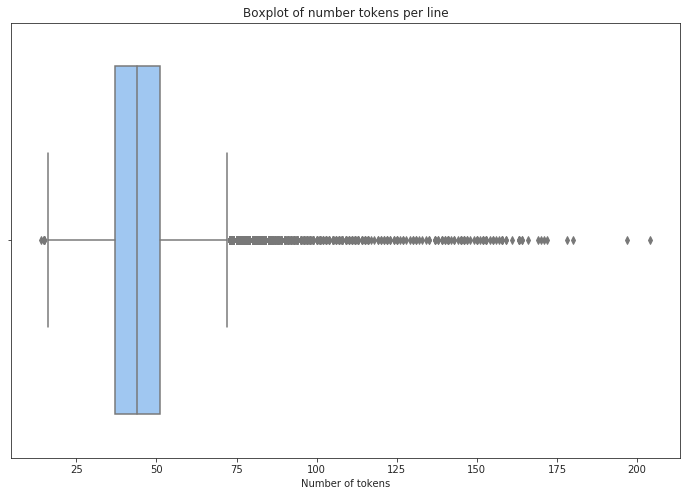

In [10]:
# Number words per line
number_tokens_per_line = train.token.str.split().str.len()

print('Statistics of number of tokens per line')
print(number_tokens_per_line.describe())

fig = sns.boxplot(number_tokens_per_line)
plt.title('Boxplot of number tokens per line')
plt.xlabel('Number of tokens');

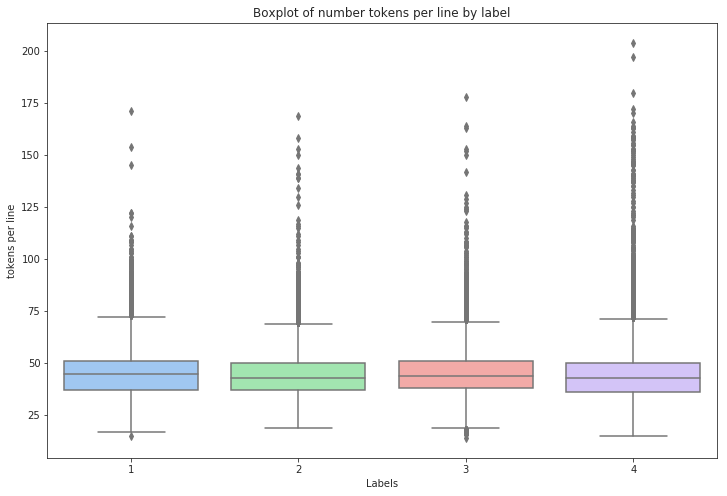

In [11]:
fig = sns.boxplot(x=train.label, y=number_tokens_per_line)
plt.title('Boxplot of number tokens per line by label')
plt.xlabel('Labels')
plt.ylabel('tokens per line');

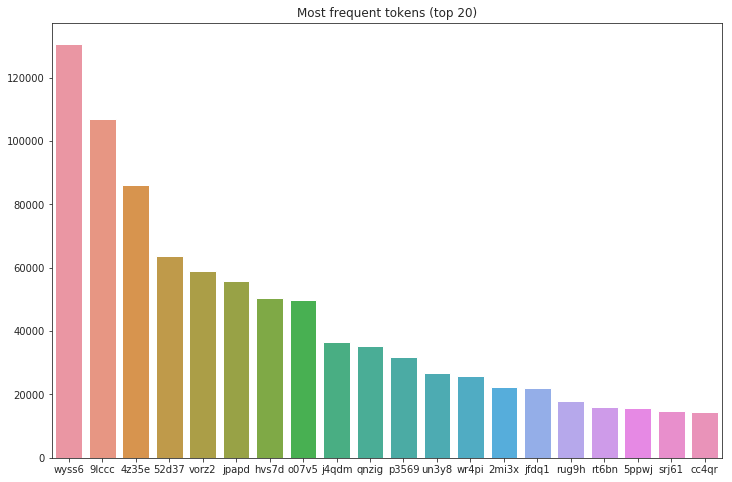

In [12]:
# most frequent tokens (top 20)
tokens_frequency = pd.Series(' '.join(train.token).split()).value_counts()[:20]
sns.barplot(x=tokens_frequency.index, y=tokens_frequency)
plt.title('Most frequent tokens (top 20)');

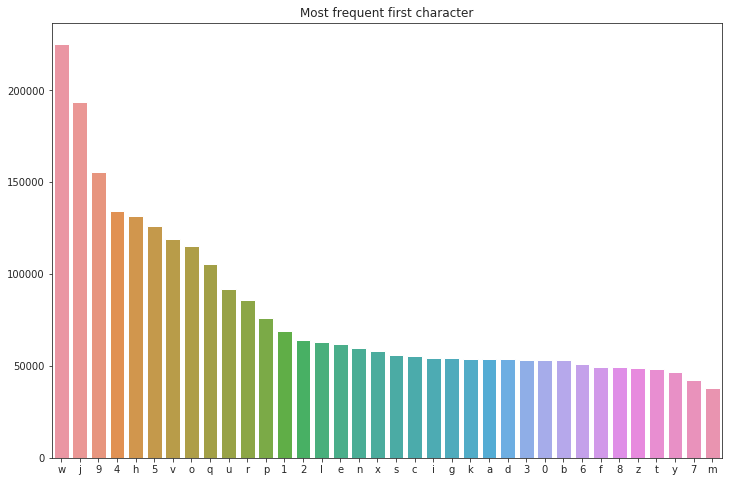

In [13]:
# Most frequent first character
first_character = pd.Series(
    ' '.join(train.token).split()).str.slice(0, 1).value_counts()
sns.barplot(x=first_character.index, y=first_character)
plt.title('Most frequent first character');

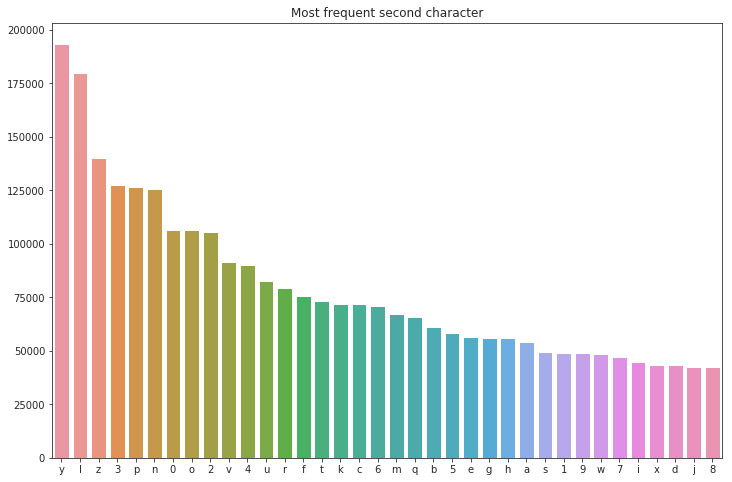

In [14]:
# Most frequent second character
second_character = pd.Series(
    ' '.join(train.token).split()).str.slice(1, 2).value_counts()
sns.barplot(x=second_character.index, y=second_character)
plt.title('Most frequent second character');

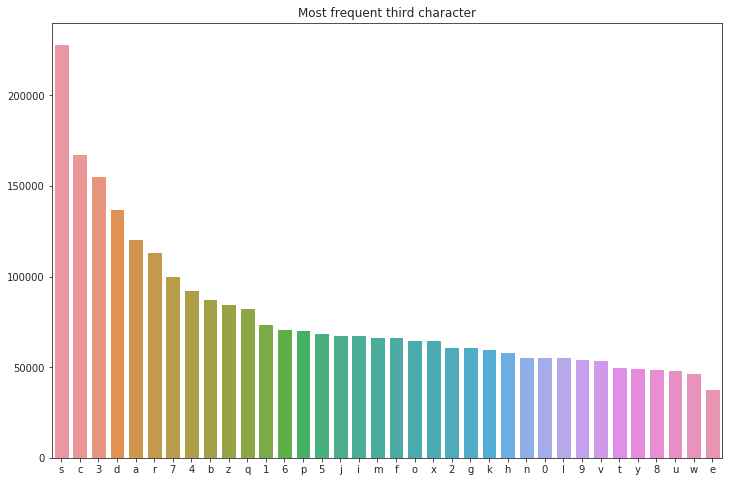

In [15]:
# Most frequent third character
third_character = pd.Series(
    ' '.join(train.token).split()).str.slice(2, 3).value_counts()
sns.barplot(x=third_character.index, y=third_character)
plt.title('Most frequent third character');

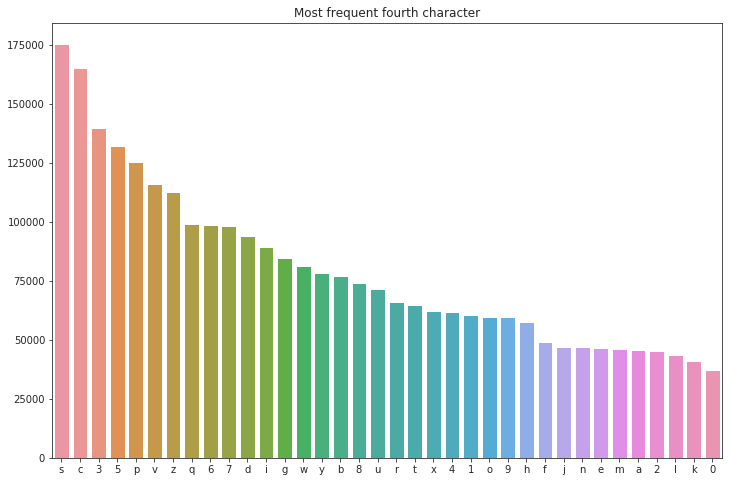

In [16]:
# Most frequent fourth character
fourth_character = pd.Series(
    ' '.join(train.token).split()).str.slice(3, 4).value_counts()
sns.barplot(x=fourth_character.index, y=fourth_character)
plt.title('Most frequent fourth character');

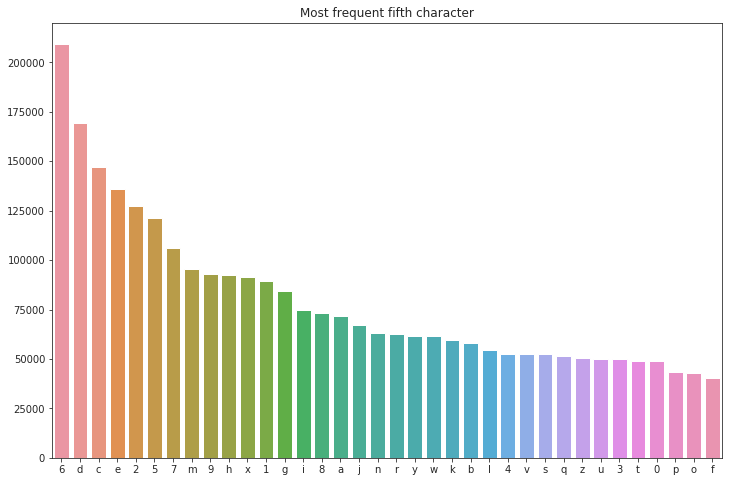

In [17]:
# Most frequent fifth character
fifth_character = pd.Series(
    ' '.join(train.token).split()).str.slice(4, 5).value_counts()
sns.barplot(x=fifth_character.index, y=fifth_character)
plt.title('Most frequent fifth character');

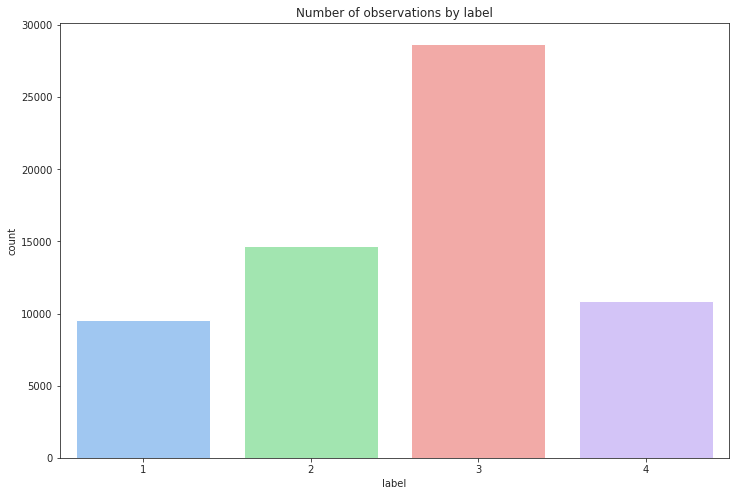

In [18]:
# Number of observations by label
sns.countplot(train.label)
plt.title('Number of observations by label');

## Split labelled data into training and validation data set. Then build your model from training data and evaluate your prediction on validation data using suitable metric. (15 pts)

In [19]:
#x_train, x_val, y_train, y_val = train_test_split(x, y, random_state=42)
Xtrain, Xval, y_train, y_val = train_test_split(train.token.values, 
                                                train.label, 
                                                train_size=0.9,
                                                stratify = train.label,
                                                random_state=123)

In [20]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.fit_transform(y_val)

In [21]:

# transform the data to matrix of count of each word
count_vect = CountVectorizer(analyzer='word', max_features= 10000)
count_vect.fit(train.token)
Xtrain_count = count_vect.transform(Xtrain)
Xval_count = count_vect.transform(Xval)

svd = TruncatedSVD(50, random_state=42) 
svd.fit(Xtrain_count)
Xtrain_count = svd.transform(Xtrain_count) # faster training and may improve accuracy
Xval_count = svd.transform(Xval_count)

# words level of TF-IDF
tfidf_word = TfidfVectorizer(analyzer='word', max_features= 10000)
tfidf_word.fit(train.token)
Xtrain_tfidf_word = tfidf_word.fit_transform(Xtrain)
Xval_tfidf_word = tfidf_word.transform(Xval)

svd = TruncatedSVD(50, random_state=42) 
svd.fit(Xtrain_tfidf_word)
Xtrain_tfidf_word = svd.transform(Xtrain_tfidf_word)
Xval_tfidf_word = svd.transform(Xval_tfidf_word)

# N-grams level of TF-IDF
tfidf_ngram = TfidfVectorizer(analyzer='word', max_features= 10000, ngram_range=(2, 3))
tfidf_ngram.fit(train.token)
Xtrain_tfidf_ngram = tfidf_ngram.transform(Xtrain)
Xval_tfidf_ngram = tfidf_ngram.transform(Xval)

svd = TruncatedSVD(50, random_state=42) 
svd.fit(Xtrain_tfidf_ngram)
Xtrain_tfidf_ngram = svd.transform(Xtrain_tfidf_ngram) 
Xval_tfidf_ngram = svd.transform(Xval_tfidf_ngram)

# TF-IDF with SVD
vectorizer_params = {
    'ngram_range': (1, 1),
    'max_df': 0.5,
    'max_features':10000,
}

vectorizer = TfidfVectorizer(**vectorizer_params)
vectorizer.fit(train.token)
tf_tr = vectorizer.transform(Xtrain)
tf_val = vectorizer.transform(Xval)

svd = TruncatedSVD(50, random_state=42) 
svd.fit(tf_tr)
Xtrain_svd = svd.transform(tf_tr) 
Xval_svd = svd.transform(tf_val)

In [52]:
def train_model(xtrain, ytrain, xtest, ytest, model=None, 
                params = None, model_type= 'sklearn'):
    train_score = 0
    test_score = 0
    test_pred = np.zeros_like(xtest)
    
    if model_type == 'sklearn':
        model.fit(xtrain, ytrain)
        pred = model.predict(xtrain)
        test_pred = model.predict(xtest)
    
    if model_type == 'xgb':
        eval_set=[(xtrain, ytrain), (xtest, ytest)]
        model = xgb.XGBClassifier(**params, silent=False, )
        model.fit(xtrain, ytrain, eval_set=eval_set, early_stopping_rounds= 10)
        pred = model.predict(xtrain, ntree_limit=model.best_ntree_limit)
        test_pred = model.predict(xtest, ntree_limit=model.best_ntree_limit)

    if model_type == 'cat':
        model = cat.CatBoostClassifier(iterations=100, **params)
        model.fit(xtrain, 
                  ytrain, 
                  verbose=False)
        pred = model.predict(xtrain)
        test_pred = model.predict(xtest).reshape(-1,)

    if model_type == 'lgb':
        dtrain = lgb.Dataset(xtrain, label=ytrain)
        dtest = lgb.Dataset(xtest, label= ytest)
        model = lgb.train(params, 
                          dtrain, 
                          valid_sets=[dtrain, dtest],
                          early_stopping_rounds=100)
        pred = np.argmax(model.predict(xtrain, num_iteration=model.best_iteration), axis=1)
        test_pred = np.argmax(model.predict(xtest, num_iteration=model.best_iteration), axis = 1)
    
    # Since the taget are imbalanced, we will use F1_score as metrics
    train_score = f1_score(ytrain, pred, average='weighted')
    print("The f1_score for training set is {:.4f}".format(train_score))
    if ytest is not None:
        print("The f1_score for validation set is {:.4f}".format(f1_score(ytest, test_pred, average='weighted')))
    print()
    return test_pred

### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, class_weight='balanced')
print("For Count Vector :")
pred = train_model(Xtrain_count, y_train, 
                      Xval_count, y_val, 
                      model=model)

print("For tfidf word level Vector")
pred = train_model(Xtrain_tfidf_word, y_train, 
                      Xval_tfidf_word, y_val, 
                      model=model)

print("For tfidf n-gram level Vector")
pred = train_model(Xtrain_tfidf_ngram, y_train, 
                      Xval_tfidf_ngram, y_val, 
                      model=model)

print("For SVD")
pred = train_model(Xtrain_svd, y_train, 
                      Xval_svd, y_val, 
                      model=model)

For Count Vector :
The f1_score for training set is 0.7526
The f1_score for validation set is 0.7530

For tfidf word level Vector
The f1_score for training set is 0.8199
The f1_score for validation set is 0.8208

For tfidf n-gram level Vector
The f1_score for training set is 0.6909
The f1_score for validation set is 0.6863

For SVD
The f1_score for training set is 0.8214
The f1_score for validation set is 0.8248



### Catboost

In [24]:
cat_params = {'learning_rate': 1,
              'random_seed': 123,
              'allow_writing_files': False}
print("For Count Vector :")
pred = train_model(Xtrain_count, y_train, 
                      Xval_count, y_val, 
                      model_type='cat', params = cat_params)

print("For tfidf word level Vector")
pred = train_model(Xtrain_tfidf_word, y_train, 
                      Xval_tfidf_word, y_val, 
                      model_type='cat', params = cat_params)

print("For tfidf n-gram level Vector")
pred = train_model(Xtrain_tfidf_ngram, y_train, 
                      Xval_tfidf_ngram, y_val, 
                      model_type='cat', params = cat_params)

print("For lda")
pred = train_model(Xtrain_svd, y_train, 
                      Xval_svd, y_val, 
                      model_type='cat', params = cat_params)

For Count Vector :
The f1_score for training set is 0.8132
The f1_score for validation set is 0.7284

For tfidf word level Vector
The f1_score for training set is 0.8762
The f1_score for validation set is 0.8213

For tfidf n-gram level Vector
The f1_score for training set is 0.7869
The f1_score for validation set is 0.7053

For lda
The f1_score for training set is 0.8782
The f1_score for validation set is 0.8232



### XGBoost

In [37]:
xgb_params = {'max_depth': 4, 'eta': 1, 'objective': 'multi:softmax',
              'num_class':4, 'eval_metric':'merror'}
print("For Count Vector :")
pred = train_model(Xtrain_count, y_train, 
                      Xval_count, y_val, 
                      model_type='xgb', params=xgb_params)

print("For tfidf word level Vector")
pred = train_model(Xtrain_tfidf_word, y_train, 
                      Xval_tfidf_word, y_val, 
                      model_type='xgb', params=xgb_params)

print("For tfidf n-gram level Vector")
pred = train_model(Xtrain_tfidf_ngram, y_train, 
                      Xval_tfidf_ngram, y_val, 
                      model_type='xgb', params=xgb_params)

print("For SVD")
pred = train_model(Xtrain_svd, y_train, 
                      Xval_svd, y_val, 
                      model_type='xgb', params=xgb_params)

For Count Vector :
[0]	validation_0-merror:0.425138	validation_1-merror:0.42884
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.42108	validation_1-merror:0.428213
[2]	validation_0-merror:0.417963	validation_1-merror:0.422727
[3]	validation_0-merror:0.413591	validation_1-merror:0.418966
[4]	validation_0-merror:0.406433	validation_1-merror:0.411129
[5]	validation_0-merror:0.402759	validation_1-merror:0.409718
[6]	validation_0-merror:0.398335	validation_1-merror:0.406426
[7]	validation_0-merror:0.393424	validation_1-merror:0.402194
[8]	validation_0-merror:0.390533	validation_1-merror:0.396552
[9]	validation_0-merror:0.388721	validation_1-merror:0.394201
[10]	validation_0-merror:0.386318	validation_1-merror:0.392163
[11]	validation_0-merror:0.383114	validation_1-merror:0.388715
[12]	validation_0-merror:0.378899	validation_1-merror:0.38558
[13]	validat

[24]	validation_0-merror:0.221442	validation_1-merror:0.228527
[25]	validation_0-merror:0.219892	validation_1-merror:0.227116
[26]	validation_0-merror:0.218429	validation_1-merror:0.225705
[27]	validation_0-merror:0.216879	validation_1-merror:0.224295
[28]	validation_0-merror:0.216009	validation_1-merror:0.223824
[29]	validation_0-merror:0.215138	validation_1-merror:0.223668
[30]	validation_0-merror:0.213901	validation_1-merror:0.222727
[31]	validation_0-merror:0.212316	validation_1-merror:0.222257
[32]	validation_0-merror:0.210627	validation_1-merror:0.221003
[33]	validation_0-merror:0.209513	validation_1-merror:0.219749
[34]	validation_0-merror:0.208241	validation_1-merror:0.218809
[35]	validation_0-merror:0.207353	validation_1-merror:0.218182
[36]	validation_0-merror:0.206134	validation_1-merror:0.218652
[37]	validation_0-merror:0.205577	validation_1-merror:0.217712
[38]	validation_0-merror:0.204148	validation_1-merror:0.217241
[39]	validation_0-merror:0.203225	validation_1-merror:0

[51]	validation_0-merror:0.289399	validation_1-merror:0.307524
[52]	validation_0-merror:0.28811	validation_1-merror:0.30674
[53]	validation_0-merror:0.287623	validation_1-merror:0.306426
[54]	validation_0-merror:0.286926	validation_1-merror:0.305486
[55]	validation_0-merror:0.286107	validation_1-merror:0.306113
[56]	validation_0-merror:0.285254	validation_1-merror:0.304232
[57]	validation_0-merror:0.284192	validation_1-merror:0.302978
[58]	validation_0-merror:0.283669	validation_1-merror:0.302194
[59]	validation_0-merror:0.283687	validation_1-merror:0.302194
[60]	validation_0-merror:0.282485	validation_1-merror:0.30094
[61]	validation_0-merror:0.281684	validation_1-merror:0.30094
[62]	validation_0-merror:0.281388	validation_1-merror:0.30047
[63]	validation_0-merror:0.280883	validation_1-merror:0.299687
[64]	validation_0-merror:0.280273	validation_1-merror:0.298903
[65]	validation_0-merror:0.279576	validation_1-merror:0.298433
[66]	validation_0-merror:0.278862	validation_1-merror:0.2976

[78]	validation_0-merror:0.166704	validation_1-merror:0.187461
[79]	validation_0-merror:0.166495	validation_1-merror:0.186364
[80]	validation_0-merror:0.165956	validation_1-merror:0.184953
[81]	validation_0-merror:0.165747	validation_1-merror:0.18558
[82]	validation_0-merror:0.165485	validation_1-merror:0.186207
[83]	validation_0-merror:0.164754	validation_1-merror:0.184796
[84]	validation_0-merror:0.164197	validation_1-merror:0.184169
[85]	validation_0-merror:0.163744	validation_1-merror:0.182915
[86]	validation_0-merror:0.163361	validation_1-merror:0.182288
[87]	validation_0-merror:0.16303	validation_1-merror:0.183229
[88]	validation_0-merror:0.162507	validation_1-merror:0.181818
[89]	validation_0-merror:0.162229	validation_1-merror:0.180408
[90]	validation_0-merror:0.161898	validation_1-merror:0.182445
[91]	validation_0-merror:0.161323	validation_1-merror:0.181505
[92]	validation_0-merror:0.160661	validation_1-merror:0.181034
[93]	validation_0-merror:0.160052	validation_1-merror:0.1

### LightGBM

In [43]:
lgb_params = { 'objective': "multiclass", 'num_class':4, "num_iterations":100}
    
print("For Count Vector :")
pred = train_model(Xtrain_count, y_train, 
                      Xval_count, y_val, 
                      model_type='lgb', params = lgb_params)

print("For tfidf word level Vector")
pred = train_model(Xtrain_tfidf_word, y_train, 
                      Xval_tfidf_word, y_val, 
                      model_type='lgb', params = lgb_params)

print("For tfidf n-gram level Vector")
pred = train_model(Xtrain_tfidf_ngram, y_train, 
                      Xval_tfidf_ngram, y_val, 
                      model_type='lgb', params = lgb_params)

print("For SVD")
pred = train_model(Xtrain_svd, y_train, 
                      Xval_svd, y_val, 
                      model_type='lgb', params = lgb_params)

For Count Vector :
[1]	training's multi_logloss: 1.24165	valid_1's multi_logloss: 1.24276
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 1.20622	valid_1's multi_logloss: 1.20923
[3]	training's multi_logloss: 1.17483	valid_1's multi_logloss: 1.17915
[4]	training's multi_logloss: 1.14662	valid_1's multi_logloss: 1.15268
[5]	training's multi_logloss: 1.12146	valid_1's multi_logloss: 1.12877
[6]	training's multi_logloss: 1.09831	valid_1's multi_logloss: 1.10739
[7]	training's multi_logloss: 1.07732	valid_1's multi_logloss: 1.08797
[8]	training's multi_logloss: 1.05745	valid_1's multi_logloss: 1.06944
[9]	training's multi_logloss: 1.03928	valid_1's multi_logloss: 1.05241
[10]	training's multi_logloss: 1.02274	valid_1's multi_logloss: 1.03751
[11]	training's multi_logloss: 1.00671	valid_1's multi_logloss: 1.02309
[12]	training's multi_logloss: 0.992413	valid_1's multi_logloss: 1.00996
[13]	training's multi_logloss: 0.97872	valid_1's multi_logloss

[9]	training's multi_logloss: 0.824914	valid_1's multi_logloss: 0.836394
[10]	training's multi_logloss: 0.799302	valid_1's multi_logloss: 0.811858
[11]	training's multi_logloss: 0.775952	valid_1's multi_logloss: 0.789457
[12]	training's multi_logloss: 0.754762	valid_1's multi_logloss: 0.769198
[13]	training's multi_logloss: 0.735401	valid_1's multi_logloss: 0.751005
[14]	training's multi_logloss: 0.717552	valid_1's multi_logloss: 0.73379
[15]	training's multi_logloss: 0.701327	valid_1's multi_logloss: 0.718551
[16]	training's multi_logloss: 0.686461	valid_1's multi_logloss: 0.704655
[17]	training's multi_logloss: 0.672295	valid_1's multi_logloss: 0.691191
[18]	training's multi_logloss: 0.659492	valid_1's multi_logloss: 0.679226
[19]	training's multi_logloss: 0.647598	valid_1's multi_logloss: 0.668059
[20]	training's multi_logloss: 0.636562	valid_1's multi_logloss: 0.658164
[21]	training's multi_logloss: 0.626473	valid_1's multi_logloss: 0.64904
[22]	training's multi_logloss: 0.616706	v

[17]	training's multi_logloss: 0.862463	valid_1's multi_logloss: 0.884498
[18]	training's multi_logloss: 0.852178	valid_1's multi_logloss: 0.874873
[19]	training's multi_logloss: 0.842423	valid_1's multi_logloss: 0.866069
[20]	training's multi_logloss: 0.833451	valid_1's multi_logloss: 0.8579
[21]	training's multi_logloss: 0.824702	valid_1's multi_logloss: 0.849751
[22]	training's multi_logloss: 0.816608	valid_1's multi_logloss: 0.842298
[23]	training's multi_logloss: 0.809091	valid_1's multi_logloss: 0.835347
[24]	training's multi_logloss: 0.801771	valid_1's multi_logloss: 0.828463
[25]	training's multi_logloss: 0.795005	valid_1's multi_logloss: 0.822184
[26]	training's multi_logloss: 0.788638	valid_1's multi_logloss: 0.816825
[27]	training's multi_logloss: 0.782579	valid_1's multi_logloss: 0.811426
[28]	training's multi_logloss: 0.776461	valid_1's multi_logloss: 0.806172
[29]	training's multi_logloss: 0.770793	valid_1's multi_logloss: 0.801595
[30]	training's multi_logloss: 0.765345	

[25]	training's multi_logloss: 0.576568	valid_1's multi_logloss: 0.602879
[26]	training's multi_logloss: 0.568746	valid_1's multi_logloss: 0.596132
[27]	training's multi_logloss: 0.561448	valid_1's multi_logloss: 0.589575
[28]	training's multi_logloss: 0.55466	valid_1's multi_logloss: 0.583899
[29]	training's multi_logloss: 0.548303	valid_1's multi_logloss: 0.578443
[30]	training's multi_logloss: 0.54205	valid_1's multi_logloss: 0.572983
[31]	training's multi_logloss: 0.536106	valid_1's multi_logloss: 0.568146
[32]	training's multi_logloss: 0.530372	valid_1's multi_logloss: 0.563295
[33]	training's multi_logloss: 0.524826	valid_1's multi_logloss: 0.558443
[34]	training's multi_logloss: 0.519621	valid_1's multi_logloss: 0.553693
[35]	training's multi_logloss: 0.514619	valid_1's multi_logloss: 0.549828
[36]	training's multi_logloss: 0.509807	valid_1's multi_logloss: 0.546127
[37]	training's multi_logloss: 0.505155	valid_1's multi_logloss: 0.542316
[38]	training's multi_logloss: 0.500641	

The Best models are lightGBM and Linear Regression for Xtrain_SVD
we will try to fine tune there parameter

In [65]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(solver='liblinear', max_iter=100, penalty="l2")

grid = {'class_weight' : ['balanced', None],
          'C' : [0.01, 0.1, 1.0, 10.0],
          'solver': ['newton-cg', 'sag', 'lbfgs']
         }

grid_search = GridSearchCV(lr, param_grid=grid, cv=5, scoring='f1_weighted')
grid_search.fit(Xtrain_svd, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

KeyboardInterrupt: 

In [64]:
lgb_params = { 'objective': "multiclass", 'num_class':4, 'max_depth':3, 'reg_lambda':150,
              "learning_rate":0.05, "num_iterations":1000, "num_leaves":20}

pred = train_model(Xtrain_svd, y_train, 
                      Xval_svd, y_val, 
                      model_type='lgb', params = lgb_params)

/home/yas/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's multi_logloss: 1.25046	valid_1's multi_logloss: 1.2505
Training until validation scores don't improve for 100 rounds.
[2]	training's multi_logloss: 1.22024	valid_1's multi_logloss: 1.22029
[3]	training's multi_logloss: 1.19235	valid_1's multi_logloss: 1.1925
[4]	training's multi_logloss: 1.16662	valid_1's multi_logloss: 1.16673
[5]	training's multi_logloss: 1.14234	valid_1's multi_logloss: 1.14248
[6]	training's multi_logloss: 1.11947	valid_1's multi_logloss: 1.11934
[7]	training's multi_logloss: 1.09814	valid_1's multi_logloss: 1.09793
[8]	training's multi_logloss: 1.07824	valid_1's multi_logloss: 1.07793
[9]	training's multi_logloss: 1.05924	valid_1's multi_logloss: 1.05876
[10]	training's multi_logloss: 1.04125	valid_1's multi_logloss: 1.04061
[11]	training's multi_logloss: 1.02486	valid_1's multi_logloss: 1.02424
[12]	training's multi_logloss: 1.00876	valid_1's multi_logloss: 1.00799
[13]	training's multi_logloss: 0.993778	valid_1's multi_logloss: 0.992973
[14]	train

[115]	training's multi_logloss: 0.583306	valid_1's multi_logloss: 0.59059
[116]	training's multi_logloss: 0.582146	valid_1's multi_logloss: 0.589585
[117]	training's multi_logloss: 0.581086	valid_1's multi_logloss: 0.58861
[118]	training's multi_logloss: 0.579995	valid_1's multi_logloss: 0.587629
[119]	training's multi_logloss: 0.578935	valid_1's multi_logloss: 0.586658
[120]	training's multi_logloss: 0.577718	valid_1's multi_logloss: 0.585566
[121]	training's multi_logloss: 0.57667	valid_1's multi_logloss: 0.584598
[122]	training's multi_logloss: 0.575617	valid_1's multi_logloss: 0.583569
[123]	training's multi_logloss: 0.574651	valid_1's multi_logloss: 0.582778
[124]	training's multi_logloss: 0.57355	valid_1's multi_logloss: 0.581786
[125]	training's multi_logloss: 0.572561	valid_1's multi_logloss: 0.580979
[126]	training's multi_logloss: 0.571474	valid_1's multi_logloss: 0.580062
[127]	training's multi_logloss: 0.570475	valid_1's multi_logloss: 0.579171
[128]	training's multi_loglos

[226]	training's multi_logloss: 0.504374	valid_1's multi_logloss: 0.522463
[227]	training's multi_logloss: 0.503945	valid_1's multi_logloss: 0.522137
[228]	training's multi_logloss: 0.503494	valid_1's multi_logloss: 0.521729
[229]	training's multi_logloss: 0.503078	valid_1's multi_logloss: 0.52138
[230]	training's multi_logloss: 0.502638	valid_1's multi_logloss: 0.521029
[231]	training's multi_logloss: 0.502209	valid_1's multi_logloss: 0.52071
[232]	training's multi_logloss: 0.501758	valid_1's multi_logloss: 0.520274
[233]	training's multi_logloss: 0.501333	valid_1's multi_logloss: 0.519916
[234]	training's multi_logloss: 0.500941	valid_1's multi_logloss: 0.519654
[235]	training's multi_logloss: 0.500546	valid_1's multi_logloss: 0.519296
[236]	training's multi_logloss: 0.500082	valid_1's multi_logloss: 0.518881
[237]	training's multi_logloss: 0.499659	valid_1's multi_logloss: 0.518515
[238]	training's multi_logloss: 0.499261	valid_1's multi_logloss: 0.518175
[239]	training's multi_logl

[338]	training's multi_logloss: 0.466843	valid_1's multi_logloss: 0.492009
[339]	training's multi_logloss: 0.466583	valid_1's multi_logloss: 0.491816
[340]	training's multi_logloss: 0.466341	valid_1's multi_logloss: 0.49165
[341]	training's multi_logloss: 0.466047	valid_1's multi_logloss: 0.491409
[342]	training's multi_logloss: 0.465791	valid_1's multi_logloss: 0.49117
[343]	training's multi_logloss: 0.4655	valid_1's multi_logloss: 0.490945
[344]	training's multi_logloss: 0.465249	valid_1's multi_logloss: 0.490698
[345]	training's multi_logloss: 0.465031	valid_1's multi_logloss: 0.49055
[346]	training's multi_logloss: 0.464778	valid_1's multi_logloss: 0.490323
[347]	training's multi_logloss: 0.464548	valid_1's multi_logloss: 0.490147
[348]	training's multi_logloss: 0.464302	valid_1's multi_logloss: 0.489975
[349]	training's multi_logloss: 0.464053	valid_1's multi_logloss: 0.489741
[350]	training's multi_logloss: 0.463807	valid_1's multi_logloss: 0.48954
[351]	training's multi_logloss:

[450]	training's multi_logloss: 0.443592	valid_1's multi_logloss: 0.47461
[451]	training's multi_logloss: 0.443393	valid_1's multi_logloss: 0.474468
[452]	training's multi_logloss: 0.443248	valid_1's multi_logloss: 0.474398
[453]	training's multi_logloss: 0.443073	valid_1's multi_logloss: 0.474311
[454]	training's multi_logloss: 0.442892	valid_1's multi_logloss: 0.474172
[455]	training's multi_logloss: 0.44273	valid_1's multi_logloss: 0.474059
[456]	training's multi_logloss: 0.442575	valid_1's multi_logloss: 0.473945
[457]	training's multi_logloss: 0.442411	valid_1's multi_logloss: 0.473833
[458]	training's multi_logloss: 0.44224	valid_1's multi_logloss: 0.473699
[459]	training's multi_logloss: 0.442073	valid_1's multi_logloss: 0.47357
[460]	training's multi_logloss: 0.44193	valid_1's multi_logloss: 0.473462
[461]	training's multi_logloss: 0.441782	valid_1's multi_logloss: 0.473359
[462]	training's multi_logloss: 0.44161	valid_1's multi_logloss: 0.473209
[463]	training's multi_logloss:

[562]	training's multi_logloss: 0.427293	valid_1's multi_logloss: 0.463219
[563]	training's multi_logloss: 0.427151	valid_1's multi_logloss: 0.463139
[564]	training's multi_logloss: 0.42702	valid_1's multi_logloss: 0.463067
[565]	training's multi_logloss: 0.426902	valid_1's multi_logloss: 0.462987
[566]	training's multi_logloss: 0.426775	valid_1's multi_logloss: 0.462895
[567]	training's multi_logloss: 0.42665	valid_1's multi_logloss: 0.462827
[568]	training's multi_logloss: 0.426527	valid_1's multi_logloss: 0.462742
[569]	training's multi_logloss: 0.426394	valid_1's multi_logloss: 0.462631
[570]	training's multi_logloss: 0.426275	valid_1's multi_logloss: 0.462566
[571]	training's multi_logloss: 0.426143	valid_1's multi_logloss: 0.462486
[572]	training's multi_logloss: 0.426018	valid_1's multi_logloss: 0.46236
[573]	training's multi_logloss: 0.42589	valid_1's multi_logloss: 0.462264
[574]	training's multi_logloss: 0.42576	valid_1's multi_logloss: 0.462192
[575]	training's multi_logloss

[672]	training's multi_logloss: 0.414544	valid_1's multi_logloss: 0.454981
[673]	training's multi_logloss: 0.41444	valid_1's multi_logloss: 0.454935
[674]	training's multi_logloss: 0.414329	valid_1's multi_logloss: 0.454864
[675]	training's multi_logloss: 0.414241	valid_1's multi_logloss: 0.454806
[676]	training's multi_logloss: 0.414124	valid_1's multi_logloss: 0.45477
[677]	training's multi_logloss: 0.414006	valid_1's multi_logloss: 0.454706
[678]	training's multi_logloss: 0.413917	valid_1's multi_logloss: 0.454639
[679]	training's multi_logloss: 0.413827	valid_1's multi_logloss: 0.454564
[680]	training's multi_logloss: 0.413725	valid_1's multi_logloss: 0.454485
[681]	training's multi_logloss: 0.413628	valid_1's multi_logloss: 0.454422
[682]	training's multi_logloss: 0.413528	valid_1's multi_logloss: 0.454388
[683]	training's multi_logloss: 0.413423	valid_1's multi_logloss: 0.454301
[684]	training's multi_logloss: 0.413335	valid_1's multi_logloss: 0.454237
[685]	training's multi_logl

[784]	training's multi_logloss: 0.40385	valid_1's multi_logloss: 0.448821
[785]	training's multi_logloss: 0.403771	valid_1's multi_logloss: 0.448734
[786]	training's multi_logloss: 0.403694	valid_1's multi_logloss: 0.448699
[787]	training's multi_logloss: 0.403619	valid_1's multi_logloss: 0.448664
[788]	training's multi_logloss: 0.403538	valid_1's multi_logloss: 0.448617
[789]	training's multi_logloss: 0.403458	valid_1's multi_logloss: 0.448573
[790]	training's multi_logloss: 0.403373	valid_1's multi_logloss: 0.448516
[791]	training's multi_logloss: 0.403278	valid_1's multi_logloss: 0.44848
[792]	training's multi_logloss: 0.403188	valid_1's multi_logloss: 0.448395
[793]	training's multi_logloss: 0.403107	valid_1's multi_logloss: 0.448342
[794]	training's multi_logloss: 0.40302	valid_1's multi_logloss: 0.44828
[795]	training's multi_logloss: 0.402923	valid_1's multi_logloss: 0.448206
[796]	training's multi_logloss: 0.402818	valid_1's multi_logloss: 0.44818
[797]	training's multi_logloss

[896]	training's multi_logloss: 0.394741	valid_1's multi_logloss: 0.443744
[897]	training's multi_logloss: 0.39467	valid_1's multi_logloss: 0.443713
[898]	training's multi_logloss: 0.394592	valid_1's multi_logloss: 0.443661
[899]	training's multi_logloss: 0.394521	valid_1's multi_logloss: 0.443599
[900]	training's multi_logloss: 0.394445	valid_1's multi_logloss: 0.44356
[901]	training's multi_logloss: 0.394373	valid_1's multi_logloss: 0.443516
[902]	training's multi_logloss: 0.39431	valid_1's multi_logloss: 0.443476
[903]	training's multi_logloss: 0.394253	valid_1's multi_logloss: 0.443423
[904]	training's multi_logloss: 0.394174	valid_1's multi_logloss: 0.443361
[905]	training's multi_logloss: 0.394104	valid_1's multi_logloss: 0.443329
[906]	training's multi_logloss: 0.394007	valid_1's multi_logloss: 0.443279
[907]	training's multi_logloss: 0.39393	valid_1's multi_logloss: 0.443261
[908]	training's multi_logloss: 0.393851	valid_1's multi_logloss: 0.4432
[909]	training's multi_logloss:

In [23]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)])

[0]	validation_0-merror:0.293507	validation_1-merror:0.289279
[1]	validation_0-merror:0.284165	validation_1-merror:0.280502
[2]	validation_0-merror:0.279212	validation_1-merror:0.277179
[3]	validation_0-merror:0.275074	validation_1-merror:0.2721
[4]	validation_0-merror:0.273924	validation_1-merror:0.272414
[5]	validation_0-merror:0.270622	validation_1-merror:0.268088
[6]	validation_0-merror:0.268031	validation_1-merror:0.265956
[7]	validation_0-merror:0.26546	validation_1-merror:0.264138
[8]	validation_0-merror:0.262743	validation_1-merror:0.261818
[9]	validation_0-merror:0.262242	validation_1-merror:0.26163
[10]	validation_0-merror:0.26011	validation_1-merror:0.25931
[11]	validation_0-merror:0.257916	validation_1-merror:0.256176
[12]	validation_0-merror:0.256202	validation_1-merror:0.255235
[13]	validation_0-merror:0.255679	validation_1-merror:0.254545
[14]	validation_0-merror:0.252774	validation_1-merror:0.252414
[15]	validation_0-merror:0.249619	validation_1-merror:0.249404
[16]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [24]:
y_pred = xgb_model.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.80      0.71      0.75      2375
           2       0.86      0.88      0.87      3733
           3       0.83      0.88      0.86      7195
           4       0.71      0.63      0.67      2647

   micro avg       0.82      0.82      0.82     15950
   macro avg       0.80      0.78      0.79     15950
weighted avg       0.81      0.82      0.81     15950



In [25]:
cat_model = CatBoostClassifier()
cat_model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)])

0:	learn: -1.3494678	test: -1.3494678	test1: -1.3491297	best: -1.3491297 (0)	total: 317ms	remaining: 5m 16s
1:	learn: -1.3170608	test: -1.3170608	test1: -1.3162037	best: -1.3162037 (1)	total: 576ms	remaining: 4m 47s
2:	learn: -1.2868569	test: -1.2868569	test1: -1.2858208	best: -1.2858208 (2)	total: 843ms	remaining: 4m 40s
3:	learn: -1.2573561	test: -1.2573561	test1: -1.2558800	best: -1.2558800 (3)	total: 1.1s	remaining: 4m 34s
4:	learn: -1.2318053	test: -1.2318053	test1: -1.2300101	best: -1.2300101 (4)	total: 1.37s	remaining: 4m 32s
5:	learn: -1.2077671	test: -1.2077671	test1: -1.2058241	best: -1.2058241 (5)	total: 1.64s	remaining: 4m 31s
6:	learn: -1.1836643	test: -1.1836643	test1: -1.1812670	best: -1.1812670 (6)	total: 1.9s	remaining: 4m 30s
7:	learn: -1.1615946	test: -1.1615946	test1: -1.1589938	best: -1.1589938 (7)	total: 2.15s	remaining: 4m 26s
8:	learn: -1.1401656	test: -1.1401656	test1: -1.1371659	best: -1.1371659 (8)	total: 2.42s	remaining: 4m 26s
9:	learn: -1.1204829	test: -1.

75:	learn: -0.6776546	test: -0.6776546	test1: -0.6700696	best: -0.6700696 (75)	total: 20.2s	remaining: 4m 6s
76:	learn: -0.6754517	test: -0.6754517	test1: -0.6679186	best: -0.6679186 (76)	total: 20.5s	remaining: 4m 5s
77:	learn: -0.6731315	test: -0.6731315	test1: -0.6656345	best: -0.6656345 (77)	total: 20.7s	remaining: 4m 5s
78:	learn: -0.6709540	test: -0.6709540	test1: -0.6635025	best: -0.6635025 (78)	total: 21s	remaining: 4m 4s
79:	learn: -0.6688478	test: -0.6688478	test1: -0.6614104	best: -0.6614104 (79)	total: 21.3s	remaining: 4m 4s
80:	learn: -0.6667049	test: -0.6667049	test1: -0.6593017	best: -0.6593017 (80)	total: 21.5s	remaining: 4m 3s
81:	learn: -0.6646866	test: -0.6646866	test1: -0.6572506	best: -0.6572506 (81)	total: 21.7s	remaining: 4m 3s
82:	learn: -0.6627782	test: -0.6627782	test1: -0.6553480	best: -0.6553480 (82)	total: 22s	remaining: 4m 2s
83:	learn: -0.6610375	test: -0.6610375	test1: -0.6535944	best: -0.6535944 (83)	total: 22.2s	remaining: 4m 2s
84:	learn: -0.6592179	t

149:	learn: -0.5781292	test: -0.5781292	test1: -0.5736884	best: -0.5736884 (149)	total: 39.6s	remaining: 3m 44s
150:	learn: -0.5772683	test: -0.5772683	test1: -0.5729125	best: -0.5729125 (150)	total: 39.9s	remaining: 3m 44s
151:	learn: -0.5764613	test: -0.5764613	test1: -0.5721462	best: -0.5721462 (151)	total: 40.1s	remaining: 3m 43s
152:	learn: -0.5757230	test: -0.5757230	test1: -0.5714945	best: -0.5714945 (152)	total: 40.4s	remaining: 3m 43s
153:	learn: -0.5750179	test: -0.5750179	test1: -0.5708054	best: -0.5708054 (153)	total: 40.7s	remaining: 3m 43s
154:	learn: -0.5740165	test: -0.5740165	test1: -0.5698635	best: -0.5698635 (154)	total: 40.9s	remaining: 3m 43s
155:	learn: -0.5732980	test: -0.5732980	test1: -0.5691445	best: -0.5691445 (155)	total: 41.2s	remaining: 3m 42s
156:	learn: -0.5724569	test: -0.5724569	test1: -0.5683833	best: -0.5683833 (156)	total: 41.4s	remaining: 3m 42s
157:	learn: -0.5717354	test: -0.5717354	test1: -0.5676967	best: -0.5676967 (157)	total: 41.7s	remaining:

223:	learn: -0.5310860	test: -0.5310860	test1: -0.5306051	best: -0.5306051 (223)	total: 59.3s	remaining: 3m 25s
224:	learn: -0.5306960	test: -0.5306960	test1: -0.5302530	best: -0.5302530 (224)	total: 59.5s	remaining: 3m 25s
225:	learn: -0.5302067	test: -0.5302067	test1: -0.5297862	best: -0.5297862 (225)	total: 59.8s	remaining: 3m 24s
226:	learn: -0.5297447	test: -0.5297447	test1: -0.5294086	best: -0.5294086 (226)	total: 1m	remaining: 3m 24s
227:	learn: -0.5292771	test: -0.5292771	test1: -0.5289953	best: -0.5289953 (227)	total: 1m	remaining: 3m 24s
228:	learn: -0.5287690	test: -0.5287690	test1: -0.5285330	best: -0.5285330 (228)	total: 1m	remaining: 3m 23s
229:	learn: -0.5283882	test: -0.5283882	test1: -0.5281889	best: -0.5281889 (229)	total: 1m	remaining: 3m 23s
230:	learn: -0.5279134	test: -0.5279134	test1: -0.5277286	best: -0.5277286 (230)	total: 1m 1s	remaining: 3m 23s
231:	learn: -0.5273881	test: -0.5273881	test1: -0.5272878	best: -0.5272878 (231)	total: 1m 1s	remaining: 3m 23s
232:

297:	learn: -0.5019817	test: -0.5019817	test1: -0.5050824	best: -0.5050824 (297)	total: 1m 18s	remaining: 3m 4s
298:	learn: -0.5016464	test: -0.5016464	test1: -0.5048263	best: -0.5048263 (298)	total: 1m 18s	remaining: 3m 4s
299:	learn: -0.5013227	test: -0.5013227	test1: -0.5045510	best: -0.5045510 (299)	total: 1m 18s	remaining: 3m 4s
300:	learn: -0.5010430	test: -0.5010430	test1: -0.5043029	best: -0.5043029 (300)	total: 1m 19s	remaining: 3m 3s
301:	learn: -0.5006209	test: -0.5006209	test1: -0.5039270	best: -0.5039270 (301)	total: 1m 19s	remaining: 3m 3s
302:	learn: -0.5003088	test: -0.5003088	test1: -0.5036416	best: -0.5036416 (302)	total: 1m 19s	remaining: 3m 3s
303:	learn: -0.4999948	test: -0.4999948	test1: -0.5033763	best: -0.5033763 (303)	total: 1m 19s	remaining: 3m 3s
304:	learn: -0.4997403	test: -0.4997403	test1: -0.5031733	best: -0.5031733 (304)	total: 1m 20s	remaining: 3m 2s
305:	learn: -0.4993611	test: -0.4993611	test1: -0.5028916	best: -0.5028916 (305)	total: 1m 20s	remaining

370:	learn: -0.4806097	test: -0.4806097	test1: -0.4878620	best: -0.4878620 (370)	total: 1m 37s	remaining: 2m 45s
371:	learn: -0.4803691	test: -0.4803691	test1: -0.4876625	best: -0.4876625 (371)	total: 1m 37s	remaining: 2m 44s
372:	learn: -0.4801113	test: -0.4801113	test1: -0.4874781	best: -0.4874781 (372)	total: 1m 38s	remaining: 2m 44s
373:	learn: -0.4799167	test: -0.4799167	test1: -0.4873202	best: -0.4873202 (373)	total: 1m 38s	remaining: 2m 44s
374:	learn: -0.4797082	test: -0.4797082	test1: -0.4871430	best: -0.4871430 (374)	total: 1m 38s	remaining: 2m 44s
375:	learn: -0.4794224	test: -0.4794224	test1: -0.4869219	best: -0.4869219 (375)	total: 1m 38s	remaining: 2m 43s
376:	learn: -0.4790980	test: -0.4790980	test1: -0.4866647	best: -0.4866647 (376)	total: 1m 39s	remaining: 2m 43s
377:	learn: -0.4788272	test: -0.4788272	test1: -0.4864750	best: -0.4864750 (377)	total: 1m 39s	remaining: 2m 43s
378:	learn: -0.4786335	test: -0.4786335	test1: -0.4863046	best: -0.4863046 (378)	total: 1m 39s	r

443:	learn: -0.4629280	test: -0.4629280	test1: -0.4740869	best: -0.4740869 (443)	total: 1m 57s	remaining: 2m 27s
444:	learn: -0.4627193	test: -0.4627193	test1: -0.4739328	best: -0.4739328 (444)	total: 1m 57s	remaining: 2m 26s
445:	learn: -0.4624925	test: -0.4624925	test1: -0.4737452	best: -0.4737452 (445)	total: 1m 57s	remaining: 2m 26s
446:	learn: -0.4622939	test: -0.4622939	test1: -0.4736129	best: -0.4736129 (446)	total: 1m 58s	remaining: 2m 26s
447:	learn: -0.4620791	test: -0.4620791	test1: -0.4734490	best: -0.4734490 (447)	total: 1m 58s	remaining: 2m 25s
448:	learn: -0.4618376	test: -0.4618376	test1: -0.4732713	best: -0.4732713 (448)	total: 1m 58s	remaining: 2m 25s
449:	learn: -0.4616555	test: -0.4616555	test1: -0.4731378	best: -0.4731378 (449)	total: 1m 58s	remaining: 2m 25s
450:	learn: -0.4614332	test: -0.4614332	test1: -0.4729671	best: -0.4729671 (450)	total: 1m 59s	remaining: 2m 25s
451:	learn: -0.4612288	test: -0.4612288	test1: -0.4728290	best: -0.4728290 (451)	total: 1m 59s	r

517:	learn: -0.4483820	test: -0.4483820	test1: -0.4637374	best: -0.4637374 (517)	total: 2m 16s	remaining: 2m 7s
518:	learn: -0.4482322	test: -0.4482322	test1: -0.4636381	best: -0.4636381 (518)	total: 2m 16s	remaining: 2m 6s
519:	learn: -0.4480138	test: -0.4480138	test1: -0.4635117	best: -0.4635117 (519)	total: 2m 17s	remaining: 2m 6s
520:	learn: -0.4477609	test: -0.4477609	test1: -0.4633752	best: -0.4633752 (520)	total: 2m 17s	remaining: 2m 6s
521:	learn: -0.4475815	test: -0.4475815	test1: -0.4632698	best: -0.4632698 (521)	total: 2m 17s	remaining: 2m 6s
522:	learn: -0.4474093	test: -0.4474093	test1: -0.4631383	best: -0.4631383 (522)	total: 2m 17s	remaining: 2m 5s
523:	learn: -0.4472166	test: -0.4472166	test1: -0.4629782	best: -0.4629782 (523)	total: 2m 18s	remaining: 2m 5s
524:	learn: -0.4471127	test: -0.4471127	test1: -0.4629079	best: -0.4629079 (524)	total: 2m 18s	remaining: 2m 5s
525:	learn: -0.4469325	test: -0.4469325	test1: -0.4628052	best: -0.4628052 (525)	total: 2m 18s	remaining

590:	learn: -0.4360104	test: -0.4360104	test1: -0.4556864	best: -0.4556864 (590)	total: 2m 36s	remaining: 1m 48s
591:	learn: -0.4358085	test: -0.4358085	test1: -0.4555495	best: -0.4555495 (591)	total: 2m 36s	remaining: 1m 48s
592:	learn: -0.4355659	test: -0.4355659	test1: -0.4553900	best: -0.4553900 (592)	total: 2m 37s	remaining: 1m 47s
593:	learn: -0.4353869	test: -0.4353869	test1: -0.4552878	best: -0.4552878 (593)	total: 2m 37s	remaining: 1m 47s
594:	learn: -0.4352569	test: -0.4352569	test1: -0.4551983	best: -0.4551983 (594)	total: 2m 37s	remaining: 1m 47s
595:	learn: -0.4351194	test: -0.4351194	test1: -0.4551181	best: -0.4551181 (595)	total: 2m 38s	remaining: 1m 47s
596:	learn: -0.4349553	test: -0.4349553	test1: -0.4550126	best: -0.4550126 (596)	total: 2m 38s	remaining: 1m 46s
597:	learn: -0.4347374	test: -0.4347374	test1: -0.4548834	best: -0.4548834 (597)	total: 2m 38s	remaining: 1m 46s
598:	learn: -0.4345175	test: -0.4345175	test1: -0.4547066	best: -0.4547066 (598)	total: 2m 38s	r

663:	learn: -0.4249864	test: -0.4249864	test1: -0.4488846	best: -0.4488846 (663)	total: 2m 56s	remaining: 1m 29s
664:	learn: -0.4248649	test: -0.4248649	test1: -0.4488017	best: -0.4488017 (664)	total: 2m 57s	remaining: 1m 29s
665:	learn: -0.4247507	test: -0.4247507	test1: -0.4487254	best: -0.4487254 (665)	total: 2m 57s	remaining: 1m 28s
666:	learn: -0.4246202	test: -0.4246202	test1: -0.4486349	best: -0.4486349 (666)	total: 2m 57s	remaining: 1m 28s
667:	learn: -0.4245117	test: -0.4245117	test1: -0.4485816	best: -0.4485816 (667)	total: 2m 57s	remaining: 1m 28s
668:	learn: -0.4243854	test: -0.4243854	test1: -0.4485116	best: -0.4485116 (668)	total: 2m 58s	remaining: 1m 28s
669:	learn: -0.4242785	test: -0.4242785	test1: -0.4484434	best: -0.4484434 (669)	total: 2m 58s	remaining: 1m 27s
670:	learn: -0.4241337	test: -0.4241337	test1: -0.4483765	best: -0.4483765 (670)	total: 2m 58s	remaining: 1m 27s
671:	learn: -0.4239784	test: -0.4239784	test1: -0.4483190	best: -0.4483190 (671)	total: 2m 58s	r

736:	learn: -0.4158112	test: -0.4158112	test1: -0.4436928	best: -0.4436928 (736)	total: 3m 15s	remaining: 1m 9s
737:	learn: -0.4157167	test: -0.4157167	test1: -0.4436398	best: -0.4436398 (737)	total: 3m 15s	remaining: 1m 9s
738:	learn: -0.4156074	test: -0.4156074	test1: -0.4435788	best: -0.4435788 (738)	total: 3m 16s	remaining: 1m 9s
739:	learn: -0.4155435	test: -0.4155435	test1: -0.4435525	best: -0.4435525 (739)	total: 3m 16s	remaining: 1m 8s
740:	learn: -0.4154513	test: -0.4154513	test1: -0.4434847	best: -0.4434847 (740)	total: 3m 16s	remaining: 1m 8s
741:	learn: -0.4153402	test: -0.4153402	test1: -0.4434502	best: -0.4434502 (741)	total: 3m 16s	remaining: 1m 8s
742:	learn: -0.4152390	test: -0.4152390	test1: -0.4433876	best: -0.4433876 (742)	total: 3m 17s	remaining: 1m 8s
743:	learn: -0.4151105	test: -0.4151105	test1: -0.4433439	best: -0.4433439 (743)	total: 3m 17s	remaining: 1m 7s
744:	learn: -0.4150245	test: -0.4150245	test1: -0.4432901	best: -0.4432901 (744)	total: 3m 17s	remaining

810:	learn: -0.4074320	test: -0.4074320	test1: -0.4389970	best: -0.4389970 (810)	total: 3m 35s	remaining: 50.1s
811:	learn: -0.4073063	test: -0.4073063	test1: -0.4389691	best: -0.4389691 (811)	total: 3m 35s	remaining: 49.9s
812:	learn: -0.4072362	test: -0.4072362	test1: -0.4389414	best: -0.4389414 (812)	total: 3m 35s	remaining: 49.6s
813:	learn: -0.4071190	test: -0.4071190	test1: -0.4388629	best: -0.4388629 (813)	total: 3m 35s	remaining: 49.3s
814:	learn: -0.4070301	test: -0.4070301	test1: -0.4387964	best: -0.4387964 (814)	total: 3m 36s	remaining: 49s
815:	learn: -0.4069091	test: -0.4069091	test1: -0.4387343	best: -0.4387343 (815)	total: 3m 36s	remaining: 48.8s
816:	learn: -0.4068268	test: -0.4068268	test1: -0.4386922	best: -0.4386922 (816)	total: 3m 36s	remaining: 48.5s
817:	learn: -0.4066463	test: -0.4066463	test1: -0.4385989	best: -0.4385989 (817)	total: 3m 36s	remaining: 48.2s
818:	learn: -0.4065458	test: -0.4065458	test1: -0.4385337	best: -0.4385337 (818)	total: 3m 37s	remaining: 

884:	learn: -0.3993555	test: -0.3993555	test1: -0.4346102	best: -0.4346102 (884)	total: 3m 54s	remaining: 30.5s
885:	learn: -0.3992439	test: -0.3992439	test1: -0.4345608	best: -0.4345608 (885)	total: 3m 54s	remaining: 30.2s
886:	learn: -0.3991841	test: -0.3991841	test1: -0.4345299	best: -0.4345299 (886)	total: 3m 54s	remaining: 29.9s
887:	learn: -0.3991290	test: -0.3991290	test1: -0.4345046	best: -0.4345046 (887)	total: 3m 55s	remaining: 29.6s
888:	learn: -0.3989775	test: -0.3989775	test1: -0.4344433	best: -0.4344433 (888)	total: 3m 55s	remaining: 29.4s
889:	learn: -0.3988746	test: -0.3988746	test1: -0.4343772	best: -0.4343772 (889)	total: 3m 55s	remaining: 29.1s
890:	learn: -0.3987967	test: -0.3987967	test1: -0.4343299	best: -0.4343299 (890)	total: 3m 55s	remaining: 28.9s
891:	learn: -0.3987287	test: -0.3987287	test1: -0.4343094	best: -0.4343094 (891)	total: 3m 56s	remaining: 28.6s
892:	learn: -0.3986135	test: -0.3986135	test1: -0.4342557	best: -0.4342557 (892)	total: 3m 56s	remaining

958:	learn: -0.3925703	test: -0.3925703	test1: -0.4310919	best: -0.4310919 (958)	total: 4m 13s	remaining: 10.8s
959:	learn: -0.3924865	test: -0.3924865	test1: -0.4310582	best: -0.4310582 (959)	total: 4m 13s	remaining: 10.6s
960:	learn: -0.3923947	test: -0.3923947	test1: -0.4310166	best: -0.4310166 (960)	total: 4m 13s	remaining: 10.3s
961:	learn: -0.3921869	test: -0.3921869	test1: -0.4309117	best: -0.4309117 (961)	total: 4m 14s	remaining: 10s
962:	learn: -0.3921107	test: -0.3921107	test1: -0.4308818	best: -0.4308818 (962)	total: 4m 14s	remaining: 9.78s
963:	learn: -0.3920128	test: -0.3920128	test1: -0.4308367	best: -0.4308367 (963)	total: 4m 14s	remaining: 9.51s
964:	learn: -0.3919555	test: -0.3919555	test1: -0.4308017	best: -0.4308017 (964)	total: 4m 14s	remaining: 9.25s
965:	learn: -0.3919033	test: -0.3919033	test1: -0.4307831	best: -0.4307831 (965)	total: 4m 15s	remaining: 8.98s
966:	learn: -0.3918194	test: -0.3918194	test1: -0.4307438	best: -0.4307438 (966)	total: 4m 15s	remaining: 

In [26]:
y_pred = cat_model.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.76      0.79      2375
           2       0.88      0.91      0.89      3733
           3       0.87      0.89      0.88      7195
           4       0.74      0.70      0.72      2647

   micro avg       0.84      0.84      0.84     15950
   macro avg       0.83      0.81      0.82     15950
weighted avg       0.84      0.84      0.84     15950



### Neural Network

In [ ]:
from keras.callbacks import Callback
class Metrics(Callback):
    def on_train_begin(self, logs={}):
         self.f1s = []
 
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _f1 = f1_score(val_targ, val_predict, average='weighted')
        self.f1s.append(_val_f1)
        print " — val_f1: {:.4f}" %(_val_f1)
        return
f1_metric = Metrics()

In [27]:
nn_model = Sequential()
nn_model.add(Dense(32, kernel_initializer='he_uniform', input_shape=(50,))) 
#nn_model.add(BatchNormalization())
nn_model.add(Activation('relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform')) 
#model.add(BatchNormalization())
nn_model.add(Activation('relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(5, activation='softmax'))

nn_model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc']);

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [29]:
history = nn_model.fit(x_train, y_train, 
                    epochs=200,
                    batch_size=128,
                    validation_data=(x_val, y_val)
                    callbacks = [f1_metric])

Instructions for updating:
Use tf.cast instead.
Train on 47849 samples, validate on 15950 samples
Epoch 1/200
47849/47849 [==============================] - 1s 20us/step - loss: 0.9279 - acc: 0.6448 - val_loss: 0.4860 - val_acc: 0.8265
Epoch 2/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.5460 - acc: 0.8060 - val_loss: 0.4492 - val_acc: 0.8386
Epoch 3/200
47849/47849 [==============================] - 1s 13us/step - loss: 0.5116 - acc: 0.8195 - val_loss: 0.4387 - val_acc: 0.8429
Epoch 4/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4991 - acc: 0.8238 - val_loss: 0.4341 - val_acc: 0.8443
Epoch 5/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4871 - acc: 0.8298 - val_loss: 0.4281 - val_acc: 0.8452
Epoch 6/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4780 - acc: 0.8329 - val_loss: 0.4239 - val_acc: 0.8483
Epoch 7/200
47849/47849 [==============================] - 1s 12us/step - 

Epoch 58/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4137 - acc: 0.8520 - val_loss: 0.3798 - val_acc: 0.8609
Epoch 59/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4151 - acc: 0.8513 - val_loss: 0.3800 - val_acc: 0.8606
Epoch 60/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4141 - acc: 0.8527 - val_loss: 0.3792 - val_acc: 0.8619
Epoch 61/200
47849/47849 [==============================] - 1s 13us/step - loss: 0.4128 - acc: 0.8548 - val_loss: 0.3804 - val_acc: 0.8605
Epoch 62/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4108 - acc: 0.8516 - val_loss: 0.3780 - val_acc: 0.8619
Epoch 63/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4120 - acc: 0.8531 - val_loss: 0.3798 - val_acc: 0.8613
Epoch 64/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4155 - acc: 0.8530 - val_loss: 0.3809 - val_acc: 0.8614
Epoch 65/200
47849/47849 [=

Epoch 117/200
47849/47849 [==============================] - 0s 10us/step - loss: 0.4087 - acc: 0.8534 - val_loss: 0.3751 - val_acc: 0.8634
Epoch 118/200
47849/47849 [==============================] - 1s 10us/step - loss: 0.4078 - acc: 0.8528 - val_loss: 0.3741 - val_acc: 0.8628
Epoch 119/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4076 - acc: 0.8537 - val_loss: 0.3738 - val_acc: 0.8642
Epoch 120/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4057 - acc: 0.8535 - val_loss: 0.3753 - val_acc: 0.8620
Epoch 121/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4080 - acc: 0.8534 - val_loss: 0.3749 - val_acc: 0.8628
Epoch 122/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4098 - acc: 0.8532 - val_loss: 0.3766 - val_acc: 0.8620
Epoch 123/200
47849/47849 [==============================] - 1s 12us/step - loss: 0.4061 - acc: 0.8549 - val_loss: 0.3757 - val_acc: 0.8639
Epoch 124/200
47849/

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes= 4)

In [ ]:
maxlen = 100
maxwords = 10000
embedding_size = 32

tokenizer = Tokenizer(num_words=maxwords)
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
Xtrain_seq = pad_sequences(tokenizer.texts_to_sequences(Xtrain), maxlen=maxlen)
Xval_seq = pad_sequences(tokenizer.texts_to_sequences(Xval), maxlen=maxlen)
print("shape of train data ", Xtrain_seq.shape)
print("The number of token ", len(word_index))

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim = maxwords, output_dim = embedding_size, input_length = maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(Xtrain_seq, y_train_cat, epochs=10, batch_size=32, validation_data=(Xval_seq, y_val_cat))

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim = maxwords, output_dim = embedding_size, input_length = maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(Xtrain_seq, y_train_cat, epochs=20, batch_size=128, validation_data=(Xval_seq, y_val_cat))

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim = maxwords, output_dim = embedding_size, input_length = maxlen))
model.add(layers.SpatialDropout1D(0.5))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(Xtrain_seq, y_train_cat, epochs=20, batch_size=128, validation_data=(Xval_seq, y_val_cat))

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim = maxwords, output_dim = embedding_size, input_length = maxlen))
model.add(layers.SpatialDropout1D(0.5))
model.add(layers.LSTM(32))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(Xtrain_seq, y_train_cat, epochs=20, batch_size=128, validation_data=(Xval_seq, y_val_cat))

In [ ]:
model = Sequential()
model.add(layers.Embedding(input_dim = maxwords, output_dim = embedding_size, input_length = maxlen))
model.add(layers.SpatialDropout1D(0.5))
model.add(layers.Bidirectional(layers.GRU(64))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.fit(Xtrain_seq, y_train_cat, epochs=20, batch_size=128, validation_data=(Xval_seq, y_val_cat))

## Build a prediction model from training data and predict on testing data. (60pts) 

In [30]:
# fit catboost model with all train data
model = CatBoostClassifier()
model.fit(x, y)

0:	learn: -1.3485792	total: 67.7ms	remaining: 1m 7s
1:	learn: -1.3141436	total: 136ms	remaining: 1m 7s
2:	learn: -1.2827621	total: 197ms	remaining: 1m 5s
3:	learn: -1.2546594	total: 260ms	remaining: 1m 4s
4:	learn: -1.2275674	total: 330ms	remaining: 1m 5s
5:	learn: -1.2028328	total: 391ms	remaining: 1m 4s
6:	learn: -1.1789833	total: 456ms	remaining: 1m 4s
7:	learn: -1.1567214	total: 519ms	remaining: 1m 4s
8:	learn: -1.1365242	total: 586ms	remaining: 1m 4s
9:	learn: -1.1164021	total: 649ms	remaining: 1m 4s
10:	learn: -1.0986254	total: 708ms	remaining: 1m 3s
11:	learn: -1.0807763	total: 773ms	remaining: 1m 3s
12:	learn: -1.0636782	total: 841ms	remaining: 1m 3s
13:	learn: -1.0476900	total: 905ms	remaining: 1m 3s
14:	learn: -1.0333731	total: 964ms	remaining: 1m 3s
15:	learn: -1.0193442	total: 1.02s	remaining: 1m 3s
16:	learn: -1.0057369	total: 1.09s	remaining: 1m 3s
17:	learn: -0.9925707	total: 1.15s	remaining: 1m 2s
18:	learn: -0.9801591	total: 1.21s	remaining: 1m 2s
19:	learn: -0.9681572

160:	learn: -0.5649085	total: 9.83s	remaining: 51.2s
161:	learn: -0.5641956	total: 9.9s	remaining: 51.2s
162:	learn: -0.5635702	total: 9.96s	remaining: 51.2s
163:	learn: -0.5628690	total: 10s	remaining: 51.1s
164:	learn: -0.5621813	total: 10.1s	remaining: 51.1s
165:	learn: -0.5613930	total: 10.2s	remaining: 51s
166:	learn: -0.5606801	total: 10.2s	remaining: 51s
167:	learn: -0.5599327	total: 10.3s	remaining: 51s
168:	learn: -0.5592597	total: 10.4s	remaining: 50.9s
169:	learn: -0.5586466	total: 10.4s	remaining: 50.9s
170:	learn: -0.5579542	total: 10.5s	remaining: 50.8s
171:	learn: -0.5572389	total: 10.5s	remaining: 50.8s
172:	learn: -0.5565661	total: 10.6s	remaining: 50.7s
173:	learn: -0.5558467	total: 10.7s	remaining: 50.6s
174:	learn: -0.5552129	total: 10.7s	remaining: 50.5s
175:	learn: -0.5545660	total: 10.8s	remaining: 50.5s
176:	learn: -0.5539433	total: 10.8s	remaining: 50.4s
177:	learn: -0.5533264	total: 10.9s	remaining: 50.3s
178:	learn: -0.5526949	total: 11s	remaining: 50.3s
179:

319:	learn: -0.4917309	total: 19.4s	remaining: 41.3s
320:	learn: -0.4914122	total: 19.5s	remaining: 41.3s
321:	learn: -0.4911028	total: 19.6s	remaining: 41.2s
322:	learn: -0.4907987	total: 19.6s	remaining: 41.2s
323:	learn: -0.4905476	total: 19.7s	remaining: 41.1s
324:	learn: -0.4902622	total: 19.8s	remaining: 41.1s
325:	learn: -0.4899715	total: 19.8s	remaining: 41s
326:	learn: -0.4897124	total: 19.9s	remaining: 41s
327:	learn: -0.4894198	total: 20s	remaining: 40.9s
328:	learn: -0.4891347	total: 20s	remaining: 40.8s
329:	learn: -0.4888080	total: 20.1s	remaining: 40.8s
330:	learn: -0.4885197	total: 20.1s	remaining: 40.7s
331:	learn: -0.4882174	total: 20.2s	remaining: 40.6s
332:	learn: -0.4879522	total: 20.3s	remaining: 40.6s
333:	learn: -0.4877347	total: 20.3s	remaining: 40.5s
334:	learn: -0.4874287	total: 20.4s	remaining: 40.5s
335:	learn: -0.4871760	total: 20.4s	remaining: 40.4s
336:	learn: -0.4869381	total: 20.5s	remaining: 40.3s
337:	learn: -0.4866399	total: 20.6s	remaining: 40.3s
3

477:	learn: -0.4545500	total: 28.8s	remaining: 31.4s
478:	learn: -0.4543198	total: 28.8s	remaining: 31.3s
479:	learn: -0.4540779	total: 28.9s	remaining: 31.3s
480:	learn: -0.4538324	total: 28.9s	remaining: 31.2s
481:	learn: -0.4536832	total: 29s	remaining: 31.2s
482:	learn: -0.4534261	total: 29s	remaining: 31.1s
483:	learn: -0.4532597	total: 29.1s	remaining: 31s
484:	learn: -0.4531272	total: 29.2s	remaining: 31s
485:	learn: -0.4530038	total: 29.2s	remaining: 30.9s
486:	learn: -0.4528699	total: 29.3s	remaining: 30.8s
487:	learn: -0.4526928	total: 29.3s	remaining: 30.8s
488:	learn: -0.4525218	total: 29.4s	remaining: 30.7s
489:	learn: -0.4523328	total: 29.4s	remaining: 30.6s
490:	learn: -0.4521096	total: 29.5s	remaining: 30.6s
491:	learn: -0.4519367	total: 29.6s	remaining: 30.5s
492:	learn: -0.4517584	total: 29.6s	remaining: 30.4s
493:	learn: -0.4515769	total: 29.7s	remaining: 30.4s
494:	learn: -0.4514003	total: 29.7s	remaining: 30.3s
495:	learn: -0.4512285	total: 29.8s	remaining: 30.3s
4

633:	learn: -0.4287216	total: 37.7s	remaining: 21.7s
634:	learn: -0.4285693	total: 37.7s	remaining: 21.7s
635:	learn: -0.4284505	total: 37.8s	remaining: 21.6s
636:	learn: -0.4282713	total: 37.8s	remaining: 21.6s
637:	learn: -0.4280682	total: 37.9s	remaining: 21.5s
638:	learn: -0.4279525	total: 38s	remaining: 21.4s
639:	learn: -0.4278671	total: 38s	remaining: 21.4s
640:	learn: -0.4277008	total: 38.1s	remaining: 21.3s
641:	learn: -0.4275670	total: 38.1s	remaining: 21.3s
642:	learn: -0.4274137	total: 38.2s	remaining: 21.2s
643:	learn: -0.4272238	total: 38.2s	remaining: 21.1s
644:	learn: -0.4270614	total: 38.3s	remaining: 21.1s
645:	learn: -0.4269316	total: 38.4s	remaining: 21s
646:	learn: -0.4268258	total: 38.4s	remaining: 21s
647:	learn: -0.4266954	total: 38.5s	remaining: 20.9s
648:	learn: -0.4265523	total: 38.5s	remaining: 20.8s
649:	learn: -0.4264182	total: 38.6s	remaining: 20.8s
650:	learn: -0.4262777	total: 38.6s	remaining: 20.7s
651:	learn: -0.4261185	total: 38.7s	remaining: 20.7s
6

789:	learn: -0.4092846	total: 46.6s	remaining: 12.4s
790:	learn: -0.4091960	total: 46.7s	remaining: 12.3s
791:	learn: -0.4090818	total: 46.7s	remaining: 12.3s
792:	learn: -0.4089724	total: 46.8s	remaining: 12.2s
793:	learn: -0.4088449	total: 46.8s	remaining: 12.2s
794:	learn: -0.4087565	total: 46.9s	remaining: 12.1s
795:	learn: -0.4086695	total: 47s	remaining: 12s
796:	learn: -0.4086008	total: 47s	remaining: 12s
797:	learn: -0.4084650	total: 47.1s	remaining: 11.9s
798:	learn: -0.4083691	total: 47.1s	remaining: 11.9s
799:	learn: -0.4082645	total: 47.2s	remaining: 11.8s
800:	learn: -0.4081787	total: 47.2s	remaining: 11.7s
801:	learn: -0.4080867	total: 47.3s	remaining: 11.7s
802:	learn: -0.4079396	total: 47.3s	remaining: 11.6s
803:	learn: -0.4078348	total: 47.4s	remaining: 11.6s
804:	learn: -0.4077481	total: 47.5s	remaining: 11.5s
805:	learn: -0.4076483	total: 47.5s	remaining: 11.4s
806:	learn: -0.4075665	total: 47.6s	remaining: 11.4s
807:	learn: -0.4074523	total: 47.6s	remaining: 11.3s
8

945:	learn: -0.3939673	total: 55.6s	remaining: 3.17s
946:	learn: -0.3938900	total: 55.6s	remaining: 3.11s
947:	learn: -0.3938323	total: 55.7s	remaining: 3.05s
948:	learn: -0.3937485	total: 55.7s	remaining: 3s
949:	learn: -0.3936364	total: 55.8s	remaining: 2.94s
950:	learn: -0.3935280	total: 55.9s	remaining: 2.88s
951:	learn: -0.3934382	total: 55.9s	remaining: 2.82s
952:	learn: -0.3933079	total: 56s	remaining: 2.76s
953:	learn: -0.3932084	total: 56s	remaining: 2.7s
954:	learn: -0.3931259	total: 56.1s	remaining: 2.64s
955:	learn: -0.3930360	total: 56.1s	remaining: 2.58s
956:	learn: -0.3929685	total: 56.2s	remaining: 2.52s
957:	learn: -0.3928528	total: 56.3s	remaining: 2.47s
958:	learn: -0.3927703	total: 56.3s	remaining: 2.41s
959:	learn: -0.3926579	total: 56.4s	remaining: 2.35s
960:	learn: -0.3925670	total: 56.4s	remaining: 2.29s
961:	learn: -0.3924806	total: 56.5s	remaining: 2.23s
962:	learn: -0.3924267	total: 56.5s	remaining: 2.17s
963:	learn: -0.3923507	total: 56.6s	remaining: 2.11s
9

In [31]:
test_tfidf = vectorizer.transform(test.token)
x_test = svd.transform(test_tfidf)

test['y_pred'] = model.predict(x_test)
test.to_csv('prediction.csv', index=False)

## Comments on how to improve your result (or prediction model). (10pts)

- tune model 
- find correlation between tokens and include it as a feature
- use cross validation
- add features: 
    - number of token for each document (train.token.str.len(), test.token.str.len()) (number_documents x 1)
    - average, std, min, max, median number token for each line by category (number_documents x 5)
    - add cosine similarity matrix (matrix of dimension number_documents x number_documents)
- check categories imbalance(undersampling of category3)? 